In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices

df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index, the actual EV data is handled separatel
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_201901010000_201912312359_Stunde.xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11833
1,0.10008
2,0.08593
3,0.08010
4,0.08260


In [6]:

def settings_to_target_df(pricing_type, operation_type, feed_in_type,grid_charge_type, grid_charging_allowed,hp=False,ev=False,costs=False):
    target_df = pd.read_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}_HPnew.pkl")
    if hp:
        target_df = pd.read_pickle(f"./output/detailed_consumption/HP_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}_HPnew.pkl")
    elif ev:
        target_df = pd.read_pickle(f"./output/detailed_consumption/EV_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}_HPnew.pkl")
    
    elif costs:
        target_df = pd.read_pickle(f"./output/detailed_financials/Costs_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}_HPnew.pkl")

    return target_df



In [7]:
def calculate_peaks_based_on_case(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    target_df = target_df[["Sum"]]
    heat_pump_peak_day = '2019-12-01'
    pv_peak_day = '2019-05-13'
    pv_peak = target_df["Sum"][pv_peak_day].abs().max()
    heat_pump_peak_day = '2019-12-01'
    hp_peak = target_df["Sum"][heat_pump_peak_day].abs().max()
    ev_peak_day = "2019-01-05"
    ev_peak = target_df["Sum"][ev_peak_day].abs().max()
    total_peak = target_df["Sum"].abs().max()
    
    case["worst_hp_day_peak_load"] = hp_peak
    case["worst_pv_day_peak_load"] = pv_peak
    case["worst_ev_day_peak_load"] = ev_peak
    case["worst_total_peak_load"] = total_peak
    
def calculate_agg_hp_consumption(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    total_hp_consumption = target_df["Sum"].sum()
    case["yearly_hp_consumption"] = total_hp_consumption
    
def calculate_agg_ev_consumption(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    total_ev_consumption = target_df["Sum"].sum()
    case["yearly_ev_consumption"] = total_ev_consumption

In [8]:

case_baseline = {"name":"Constant without flexibility","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "constant","grid_charging_allowed":"False"}

case_volumetric_fit_gcfalse_constant = {"name":"Constant Volumetric_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_fit_gcfalse = {"name":"Dynamic Volumetric_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_volumetric_dynamic_gcfalse_constant = {"name":"Constant Volumetric_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_dynamic_gcfalse = {"name":"Dynamic Volumetric_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_peak_fit_gcfalse_constant = {"name":"Constant Peak_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_fit_gcfalse = {"name":"Dynamic Peak_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_peak_dynamic_gcfalse_constant = {"name":"Constant Peak_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_dynamic_gcfalse = {"name":"Dynamic Peak_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_rotating_fit_gcfalse_constant = {"name":"Constant Rotating_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "rotating", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_rotating_fit_gcfalse = {"name":"Dynamic Rotating_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "rotating", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_rotating_dynamic_gcfalse_constant = {"name":"Constant Rotating_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "rotating", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_rotating_dynamic_gcfalse = {"name":"Dynamic Rotating_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "rotating", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_segmented_fit_gcfalse_constant = {"name":"Constant Segmented_FIT","feed_in_tariff" :"dynamic", "grid_charge_type" : "segmented", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_segmented_fit_gcfalse = {"name":"Dynamic Segmented_FIT","feed_in_tariff" :"dynamic", "grid_charge_type" : "segmented", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_segmented_dynamic_gcfalse_constant = {"name":"Constant Segmented_DynFeed","feed_in_tariff" :"fit", "grid_charge_type" : "segmented", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_segmented_dynamic_gcfalse = {"name":"Dynamic Segmented_DynFeed","feed_in_tariff" :"fit", "grid_charge_type" : "segmented", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}




''' Old cases:
case_volumetric_dynamic_gctrue = {"name":"Dynamic Volumetric_DynFeed_GC True","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_volumetric_fit_gctrue_constant = {"name":"Constant Volumetric_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_peak_fit_gctrue_constant = {"name":"Constant Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_peak_fit_gctrue = {"name":"Dynamic Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_volumetric_fit_gcfalse = {"name":"Dynamic Volumetric_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_fit_gctrue = {"name":"Dynamic Volumetric_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_peak_fit_gcfalse = {"name":"Dynamic Peak_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_fit_gctrue = {"name":"Dynamic Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_peak_dynamic_gctrue = {"name":"Dynamic Peak_DynFeed_GC_GC True","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}

'''


cases = [case_baseline, case_volumetric_fit_gcfalse_constant, case_volumetric_fit_gcfalse, case_volumetric_dynamic_gcfalse_constant, case_volumetric_dynamic_gcfalse, case_peak_fit_gcfalse_constant, case_peak_fit_gcfalse, case_peak_dynamic_gcfalse_constant, case_peak_dynamic_gcfalse, case_rotating_fit_gcfalse_constant, case_rotating_fit_gcfalse, case_rotating_dynamic_gcfalse_constant, case_rotating_dynamic_gcfalse,case_segmented_fit_gcfalse_constant,case_segmented_fit_gcfalse,case_segmented_dynamic_gcfalse_constant,case_segmented_dynamic_gcfalse]
for case in cases: 
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    
    calculate_peaks_based_on_case(target_df_consumption, case)
    #target_df_hp = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
    #                                                 case["grid_charging_allowed"],hp=True)
    
    #calculate_agg_hp_consumption(target_df_hp,case)
    
    #target_df_ev = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
    #                                                 case["grid_charging_allowed"],ev=True)
    
    #calculate_agg_ev_consumption(target_df_ev,case)


In [9]:
cases_comparison = pd.DataFrame(cases).set_index("name")
cases_comparison

,feed_in_tariff,grid_charge_type,pricing_type,operation_type,grid_charging_allowed,worst_hp_day_peak_load,worst_pv_day_peak_load,worst_ev_day_peak_load,worst_total_peak_load
name,,,,,,,,,
Constant without flexibility,fit,volumetric,constant,constant,False,1154.445281,2328.825837,855.697233,2488.247201
Constant Volumetric_FIT,fit,volumetric,constant,dynamic,False,1121.180707,1874.629001,791.790371,2263.190884
Dynamic Volumetric_FIT,fit,volumetric,dynamic,dynamic,False,2098.909616,1862.008773,1536.704606,2616.148604
Constant Volumetric_DynFeed,dynamic,volumetric,constant,dynamic,False,1119.965406,2168.240121,768.197258,2487.083512
Dynamic Volumetric_DynFeed,dynamic,volumetric,dynamic,dynamic,False,2124.274317,2136.477535,1533.456711,2611.047927
Constant Peak_FIT,fit,peak,constant,dynamic,False,988.380561,1897.596987,709.738485,2248.230969
Dynamic Peak_FIT,fit,peak,dynamic,dynamic,False,1638.645047,1969.627390,1294.159495,2568.332785
Constant Peak_DynFeed,dynamic,peak,constant,dynamic,False,1171.930909,2594.619258,709.605542,2649.884204
Dynamic Peak_DynFeed,dynamic,peak,dynamic,dynamic,False,1639.223208,2467.012462,1294.321080,2647.567369


In [10]:
cases_comparison[["worst_hp_day_peak_load","worst_pv_day_peak_load","worst_ev_day_peak_load","worst_total_peak_load"]].style.background_gradient(cmap='RdYlGn_r')

,worst_hp_day_peak_load,worst_pv_day_peak_load,worst_ev_day_peak_load,worst_total_peak_load
name,,,,
Constant without flexibility,1154.445281,2328.825837,855.697233,2488.247201
Constant Volumetric_FIT,1121.180707,1874.629001,791.790371,2263.190884
Dynamic Volumetric_FIT,2098.909616,1862.008773,1536.704606,2616.148604
Constant Volumetric_DynFeed,1119.965406,2168.240121,768.197258,2487.083512
Dynamic Volumetric_DynFeed,2124.274317,2136.477535,1533.456711,2611.047927
Constant Peak_FIT,988.380561,1897.596987,709.738485,2248.230969
Dynamic Peak_FIT,1638.645047,1969.627390,1294.159495,2568.332785
Constant Peak_DynFeed,1171.930909,2594.619258,709.605542,2649.884204
Dynamic Peak_DynFeed,1639.223208,2467.012462,1294.321080,2647.567369


In [11]:
cases_comparison_latex = cases_comparison.copy()
cases_comparison_latex.columns = ['FIT', 'Grid charges', 'Tariff', 'Flexibility',
       'grid_charging_allowed', 'Worst HP day',
       'Worst PV day', 'Worst EV day',
       'Worst yearly day']
cases_comparison_latex.drop("grid_charging_allowed",axis=1,inplace=True)
cases_comparison_latex.to_latex("./output/case_comparison.tex",
                          float_format="%.1f")


<ipython-input-11-e868129a75a4>:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  cases_comparison_latex.to_latex("./output/case_comparison.tex",


In [12]:
'''cases_comparison[["yearly_hp_consumption"]].style.background_gradient(cmap='RdYlGn_r')

'''

'cases_comparison[["yearly_hp_consumption"]].style.background_gradient(cmap=\'RdYlGn_r\')\n\n'

In [13]:
'''cases_comparison[["yearly_ev_consumption"]].style.background_gradient(cmap='RdYlGn_r')

'''

'cases_comparison[["yearly_ev_consumption"]].style.background_gradient(cmap=\'RdYlGn_r\')\n\n'

# Comparing load patterns

In the following, we compare resulting aggregated load patterns by policies.

In [14]:
compare_df = pd.DataFrame()

cases = [case_baseline, case_volumetric_fit_gcfalse_constant, case_volumetric_fit_gcfalse]
for case in cases:
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    compare_df[case["name"]] = target_df_consumption.sum(axis=1)
    compare_df.index = target_df_consumption.index
    
compare_df["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].values
compare_df.index = compare_df.index.strftime('%Y-%m-%d %H:%M:%S')


<ipython-input-15-a333c6c833a8>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


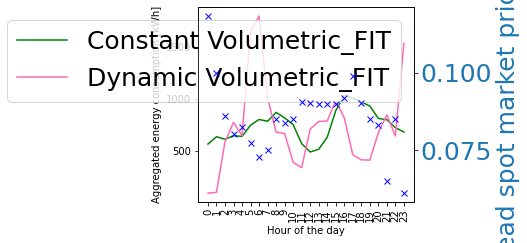

In [15]:



day = 0

fig, ax1 = plt.subplots()

plt.rcParams.update({'font.size': 25})
plt.rcParams["figure.figsize"] = (18,8)

color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Aggregated energy consumption [kWh]', color="black")
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Constant Volumetric_FIT'].iloc[day*24:(day+1)*24], color="green", label='Constant Volumetric_FIT')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Dynamic Volumetric_FIT'].iloc[day*24:(day+1)*24], color="hotpink", label='Dynamic Volumetric_FIT')
#ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Constant Rotating_FIT_GC False'].iloc[day*24:(day+1)*24], color="black", label='Constant Peak_FIT_GC False')
#ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Dynamic Rotating_FIT_GC False'].iloc[day*24:(day+1)*24], color="green", label='Dynamic Peak_FIT_GC False')
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc='upper right')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Day-ahead spot market price [€/kWh]', color=color3)
ax2.plot(compare_df.index[day*24:(day+1)*24], compare_df['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24],lw=3,color="blue", marker="x",linestyle="")
ax2.tick_params(axis='y', labelcolor=color3)
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


fig.tight_layout()  # for a neat layout


plt.show()


## Comparing household costs: constant with no flexibility vs. flexibility

In [16]:
df_compare_energy_costs = pd.DataFrame()
cases = [case_baseline, case_volumetric_fit_gcfalse_constant, case_volumetric_fit_gcfalse]
for case in cases: 
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    target_df_consumption[target_df_consumption < 0] = 0 # since we are only comparing pure energy costs, we set feed-in events at 0 
    if case["pricing_type"] == "dynamic":
        total_costs_energy = pd.DataFrame(target_df_consumption.values*df_p.values).sum()
    else:
        total_costs_energy = target_df_consumption.sum()*(df_p.mean()[0])
    df_compare_energy_costs[case["name"]] = total_costs_energy.values
    

In [17]:
df_compare_energy_costs.mean()

Constant without flexibility    875.799548
Constant Volumetric_FIT         658.575765
Dynamic Volumetric_FIT          636.763432
dtype: float64

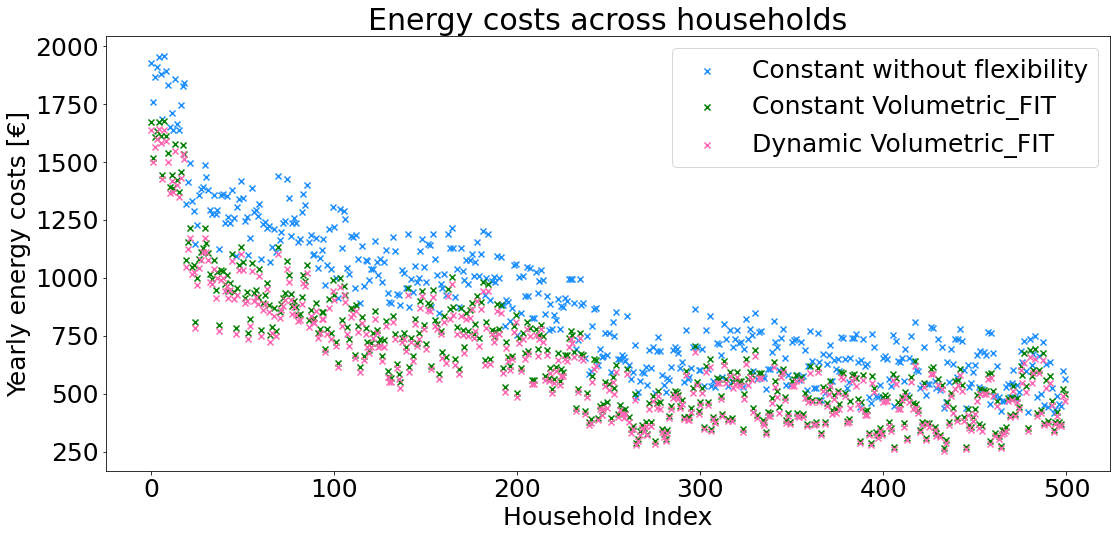

In [18]:

plt.rcParams.update({'font.size': 25})


fig, ax = plt.subplots()

# Plotting each column with a different color and label
colors = ['dodgerblue', 'green', 'hotpink']
for col, color in zip(df_compare_energy_costs.columns, colors):
    ax.scatter(df_compare_energy_costs.index, df_compare_energy_costs[col], label=col, color=color, marker ="x")

# Setting labels and title
ax.set_xlabel('Household Index')
ax.set_ylabel('Yearly energy costs [€]')
ax.set_title('Energy costs across households')
ax.legend()

# Showing the plot
plt.show()

In [19]:
df_compare_energy_costs.mean()

Constant without flexibility    875.799548
Constant Volumetric_FIT         658.575765
Dynamic Volumetric_FIT          636.763432
dtype: float64

## Comparing overall cost components

In [20]:
# Tariff settings # TODO: Shall we have a central utils.py file / config.yaml file for functions/values that are used in multiple notebooks?
feed_in_tariff_fixed = 0.1187 # 0.07
grid_charge = 0.0722 # https://www.bundesnetzagentur.de/SharedDocs/Mediathek/Monitoringberichte/Monitoringbericht_VerbraucherKennzahlen2019.pdf
peak_power_charge = 67.94 #https://www.avacon-netz.de/content/dam/revu-global/avacon-netz/documents/netzentgelte-strom
segmented_charges = [grid_charge / 2, grid_charge, grid_charge * 2] # [EUR/kWh segment 1, EUR/kWh segment 2, ...]
segmented_limits = [2,    2,    None]   # [kWh segment 1, kWh segment 2, ...]; None for the last segment

In [21]:
def get_rotating_grid_charges(length, grid_charges, idx_initial):
    # initialize
    grid_charges_final = np.full(length, grid_charges / 2)
    idx_initial = int(idx_initial)

    # define starting point
    found_starting_point = False
    starting_point = 0
    while found_starting_point is False:
        modulo_value = (idx_initial + starting_point) % 2
        if modulo_value != 0:
            starting_point = starting_point + 1
        else:
            found_starting_point = True

    # define grid charges
    offset = starting_point % 2  # starting based on household number idx_initial
    for i in range(offset, length, 2):
        grid_charges_final[i] = grid_charges * 2
    return grid_charges_final


def calculate_costs_grid(df_case, case):
    df_consumption = df_case.copy()
    df_consumption[df_consumption < 0] = 0  # no grid charges on feed-in
    length = len(df_consumption)

    # compute grid costs per household
    if case["grid_charge_type"] == "volumetric":
        costs_grid_per_hh = (df_consumption * grid_charge).sum()
    elif case["grid_charge_type"] == "peak":
        costs_grid_per_hh = df_consumption.max() * peak_power_charge
    elif case["grid_charge_type"] == "rotating":
        # the grid charges are different for different households --> calculate costs individually
        df_costs_grid = pd.DataFrame(index=df_consumption.index, columns=df_consumption.columns, data=np.nan)
        for idx_initial in df_case.columns:
            grid_charges = get_rotating_grid_charges(length, grid_charge, idx_initial)
            df_costs_grid.loc[:, idx_initial] = df_consumption.loc[:, idx_initial] * grid_charges
        costs_grid_per_hh = df_costs_grid.sum()
    elif case["grid_charge_type"] == "segmented":
        # compute the costs per segment and then sum them up
        df_costs_grid = pd.DataFrame(index=df_consumption.index, columns=df_consumption.columns, data=0)
        for s in range(len(segmented_charges) - 1, -1, -1):
            lower_limit = sum(segmented_limits[:s])
            # print(f"Processing segment {s}; lower limit: {lower_limit} kWh")
            df_segment = df_consumption - lower_limit
            df_segment[df_segment < 0] = 0
            df_costs_grid += df_segment * segmented_charges[s]
            df_consumption = df_consumption - df_segment
        assert df_consumption.sum().sum() >= -1e-5 and df_consumption.sum().sum() <= 1e-5
        costs_grid_per_hh = df_costs_grid.sum()

    # compute total grid costs
    total_costs_grid = costs_grid_per_hh.sum()

    return total_costs_grid


def calculate_costs_energy(df_case, case):
    df_consumption = df_case.copy()
    df_consumption[df_consumption < 0] = 0

    # compute energy costs per household
    if case["pricing_type"] == "constant":
        costs_energy_per_hh = df_consumption.sum() * df_p.mean()[0]
    elif case["pricing_type"] == "dynamic":
        costs_energy_per_hh = df_consumption.values * df_p.values

    # compute total energy costs
    total_costs_energy = costs_energy_per_hh.sum()

    return total_costs_energy


def calculate_feed_in_profits(df_case, case):
    df_feedin = df_case.copy()
    df_feedin[df_feedin > 0] = 0
    df_feedin = df_feedin.abs()

    # compute feed-in profits per household
    if case["feed_in_tariff"] == "fit":
        feed_in_profits_per_hh = df_feedin.sum() * feed_in_tariff_fixed
    elif case["feed_in_tariff"] == "dynamic":
        feed_in_profits_per_hh = df_feedin.values * df_p.values

    # compute total feed-in profits
    total_feed_in_profits = feed_in_profits_per_hh.sum()

    return total_feed_in_profits

In [22]:
for case in cases:
    df_case = settings_to_target_df(pricing_type=case["pricing_type"],
                                    operation_type=case["operation_type"],
                                    feed_in_type=case["feed_in_tariff"],
                                    grid_charge_type=case["grid_charge_type"],
                                    grid_charging_allowed=case["grid_charging_allowed"])
    case["costs_grid"] = calculate_costs_grid(df_case, case)
    case["costs_energy"] = calculate_costs_energy(df_case, case)
    case["feed_in_profits"] = calculate_feed_in_profits(df_case, case)
    case["net_costs"] = case["costs_grid"] + case["costs_energy"] - case["feed_in_profits"]

In [23]:
cases_comparison_incl_costs = pd.DataFrame(cases).set_index("name")
cases_comparison_latex = cases_comparison_incl_costs.copy()
cases_comparison_latex.columns = ['FIT', 'Grid charges', 'Tariff', 'Flexibility',
       'grid_charging_allowed', 'Worst HP day',
       'Worst PV day', 'Worst EV day', 'Worst yearly day',
       'Grid costs', 'Energy costs', 'Feed-in profits', 'Net costs']
cases_comparison_latex.drop("grid_charging_allowed",axis=1,inplace=True)
cases_comparison_latex.to_latex("./output/case_comparison_incl_costs.tex",
                          float_format="%.1f")

<ipython-input-23-452dd4c04b90>:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  cases_comparison_latex.to_latex("./output/case_comparison_incl_costs.tex",
